# Orientation of a linear molecule using strong THz fields

Simulate orientation of OCS linear molecule produced by a strong THz filed of the kind reported in ["Optical generation of single-cycle 10 MW peak power 100 GHz waves", X. Wu, et al., Opt. Express 24, 21059 (2016)](https://doi.org/10.1364/OE.24.021059)

In [1]:
from field_free import field_free_linear
from stark import dipole_me_matrix, field_free_matrix
from thz_field import thz_field
from tdse import propagate
from constants import DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS, LIGHT_SPEED_CM_PER_PS

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

### Molecular data for OCS molecule

In [2]:
# rotational constant in 1/cm
rot_b = 0.203

# dipole moment in Debye
dipole_debye = (0, 0, 0.715)

### Field-free rotational energies and wavefunctions

In [3]:
max_j = 6

rot_enr = {}
rot_vec = {}
rot_assignment = {}
rot_func_on_grid = {}

for j in range(max_j + 1):
    rot_enr[j], rot_vec[j], rot_assignment[j], grid, rot_func_on_grid[j] = (
        field_free_linear(j, rot_b)
    )

Print rotational energies and assignments

In [4]:
print("Rotational energies\n# (J, ka, kc)  E (MHz)")
for j in rot_enr.keys():
    for i, (e, (j, ka, kc)) in enumerate(zip(rot_enr[j], rot_assignment[j])):
        print(i, (j, ka, kc), e.round(6))

Rotational energies
# (J, ka, kc)  E (MHz)
0 (0, 0, 0) 0.0
0 (1, 0, 0) 0.406
0 (2, 0, 0) 1.218
0 (3, 0, 0) 2.436
0 (4, 0, 0) 4.06
0 (5, 0, 0) 6.09
0 (6, 0, 0) 8.526


### Rotational matrix elements of dipole moment operator

In [5]:
# dipole matrix elelements
dipole_matrix = dipole_me_matrix(max_j, rot_vec, dipole_debye, linear=True) # NOTE: linear=True for linear molecule

# field-free Hamiltonian - diagonal matrix with rotational energies
h0_matrix, assignment = field_free_matrix(max_j, rot_enr, rot_assignment)

Print assignments of rotational states, including the $m$-degeneracy

In [6]:
print("Rotational energies\n# (J, ka, kc, m)  E (MHz)")
for i, (j, ka, kc, m) in enumerate(assignment):
    print(i, (j, ka, kc, m), h0_matrix[i, i].round(6))

Rotational energies
# (J, ka, kc, m)  E (MHz)
0 (0, 0, 0, 0) 0.0
1 (1, 0, 0, -1) 0.406
2 (1, 0, 0, 0) 0.406
3 (1, 0, 0, 1) 0.406
4 (2, 0, 0, -2) 1.218
5 (2, 0, 0, -1) 1.218
6 (2, 0, 0, 0) 1.218
7 (2, 0, 0, 1) 1.218
8 (2, 0, 0, 2) 1.218
9 (3, 0, 0, -3) 2.436
10 (3, 0, 0, -2) 2.436
11 (3, 0, 0, -1) 2.436
12 (3, 0, 0, 0) 2.436
13 (3, 0, 0, 1) 2.436
14 (3, 0, 0, 2) 2.436
15 (3, 0, 0, 3) 2.436
16 (4, 0, 0, -4) 4.06
17 (4, 0, 0, -3) 4.06
18 (4, 0, 0, -2) 4.06
19 (4, 0, 0, -1) 4.06
20 (4, 0, 0, 0) 4.06
21 (4, 0, 0, 1) 4.06
22 (4, 0, 0, 2) 4.06
23 (4, 0, 0, 3) 4.06
24 (4, 0, 0, 4) 4.06
25 (5, 0, 0, -5) 6.09
26 (5, 0, 0, -4) 6.09
27 (5, 0, 0, -3) 6.09
28 (5, 0, 0, -2) 6.09
29 (5, 0, 0, -1) 6.09
30 (5, 0, 0, 0) 6.09
31 (5, 0, 0, 1) 6.09
32 (5, 0, 0, 2) 6.09
33 (5, 0, 0, 3) 6.09
34 (5, 0, 0, 4) 6.09
35 (5, 0, 0, 5) 6.09
36 (6, 0, 0, -6) 8.526
37 (6, 0, 0, -5) 8.526
38 (6, 0, 0, -4) 8.526
39 (6, 0, 0, -3) 8.526
40 (6, 0, 0, -2) 8.526
41 (6, 0, 0, -1) 8.526
42 (6, 0, 0, 0) 8.526
43 (6, 0, 0, 1) 8.5

### Define THz field

Use field provided by `thz_field` module, which is a digitized version of the Figure 4 in ["Optical generation of single-cycle 10 MW peak power 100 GHz waves", X. Wu, et al., Opt. Express 24, 21059 (2016)](https://doi.org/10.1364/OE.24.021059)

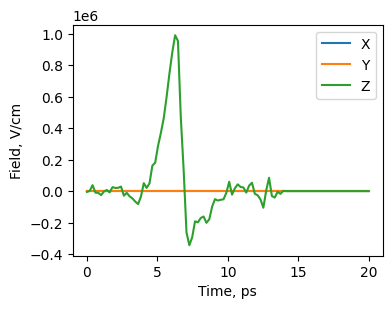

In [7]:
# field, in V/cm, as a function of time, in picoseconds
field = lambda time: np.array([0, 0, thz_field(time, peak_field=100e4)])

time = np.linspace(0, 20, 100)
plt.figure(figsize=(4, 3))
plt.plot(time, np.array([field(t) for t in time]), label=["X", "Y", "Z"])
plt.xlabel("Time, ps")
plt.ylabel("Field, V/cm")
plt.legend()
plt.show()

### Propagate

Solve time-dependent Schrödinger equation with THz field. Molecule initially in the ground rotational state.

In [8]:
# convert field-free Hamiltonian from 1/cm to 1/ps
h0_matrix_invps = h0_matrix * LIGHT_SPEED_CM_PER_PS

# convert dipole matrix elelements to units cm/(V*ps)
# to make sure that when it is multiplied with field in V/cm, the final units will be 1/ps
dipole_matrix_invps = dipole_matrix * DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS

# solve TDSE

# initial population - ground state only
coefs = np.zeros(len(h0_matrix_invps))
coefs[0] = 1.0

coefs_time = propagate(
    start_time=0.0,
    end_time=200,
    time_step=0.01,
    field=field,
    field_free_matrix=h0_matrix_invps,
    dipole_matrix=dipole_matrix_invps,
    initial_coefs=coefs,
    on_update=lambda i, t, c: (  # print population of state no. 0 at each 100th timestep
        print(
            t.round(2),
            np.abs(c[0]) ** 2,
        )
        if i % 100 == 0
        else None
    ),
)

# keep only every 10th element (resulting time-resolution 0.1 ps)
coefs_time = coefs_time[0::10]

0.0 0.999999995806903
1.0 0.9999996094357856
2.0 0.9999913809038321
3.0 0.9999549539738455
4.0 0.9974316586193644
5.0 0.993576005000856
6.0 0.5419621110302845
7.0 0.016608086294231605
8.0 0.13226840923048963
9.0 0.2666588932086567
10.0 0.30822499696858935
11.0 0.28640270443871924
12.0 0.2723892697502868
13.0 0.29057204146433524
14.0 0.30273768015887126
15.0 0.30273768015887126
16.0 0.30273768015887126
17.0 0.30273768015887126
18.0 0.30273768015887126
19.0 0.30273768015887126
20.0 0.30273768015887126
21.0 0.30273768015887126
22.0 0.30273768015887126
23.0 0.30273768015887126
24.0 0.30273768015887126
25.0 0.30273768015887126
26.0 0.30273768015887126
27.0 0.30273768015887126
28.0 0.30273768015887126
29.0 0.30273768015887126
30.0 0.30273768015887126
31.0 0.30273768015887126
32.0 0.30273768015887126
33.0 0.30273768015887126
34.0 0.30273768015887126
35.0 0.30273768015887126
36.0 0.30273768015887126
37.0 0.30273768015887126
38.0 0.30273768015887126
39.0 0.30273768015887126
40.0 0.3027376801588

### Plot populations of states

Plot time-evolution of populations for different rotational states

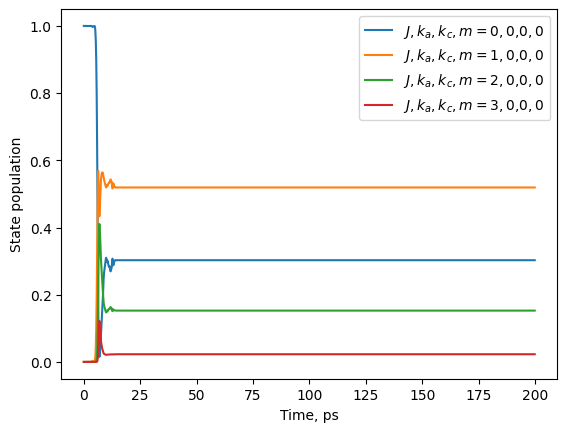

In [9]:
plot_thresh = 1e-1

# extract time grid
time_list = np.array([time for (ind, time, coef) in coefs_time])

# extract populations
populations_time = np.array([np.abs(coef) ** 2 for (ind, time, coef) in coefs_time])

# plot significant populations
for state_ind, population in enumerate(populations_time.T):
    if np.max(population) > plot_thresh:
        label = "$J,k_a,k_c,m=$"+",".join(f"{elem}$" for elem in assignment[state_ind])
        plt.plot(time_list, population, label=label)
plt.xlabel("Time, ps")
plt.ylabel("State population")
plt.legend()
plt.show()

### Evaluate degree of orientation

The degree of orientation is defined by the expectation value of the $\cos\beta$ function:

$$
\langle\psi(t) |\cos\theta|\psi(t)\rangle,
$$

where $\theta$ is the angle between the dipole moment vector in the molecular frame and the field polarisation axis in the laboratory frame, and $\psi(t)$ is the rotational wavepacket.
Note, the rotational wavepacket is also a function of three Euler angles: $\alpha$, $\beta$, and $\gamma$.
For shortness, these variables are skipped in our notation.

To compute the expectation value, we can employ a Monte Carlo method. This approach involves approximating the integral that represents the expectation value as a sum over a discrete set of points that are sampled based on the density. Specifically, the expectation value can be approximated as follows:

$$
\langle\psi(t) |\cos\theta|\psi(t)\rangle = \int \psi^*(t)\psi(t) \cos\theta d\alpha d\beta\sin\beta d\gamma =  \int \rho(t) \cos\theta d\alpha d\beta d\gamma
\approx \sum_{\{\alpha_g,\beta_g,\gamma_g\} \sim \rho(t)}^{N_g} \cos\theta(\alpha_g,\beta_g,\gamma_g),
$$

where $\rho(t) = \psi^*(t)\psi(t)\sin\beta$ is introduced as the rotational density function.

Extending this approach, we can map the discretely sampled Euler angles $\{\alpha_g,\beta_g,\gamma_g\}_g^{N_g}$,
which are distributed according to the rotational density $\rho(t)$, to the elements of the direction-cosine
rotation matrix $R{(3\times 3)}$ that rotates a vector from the molecular to the laboratory frame.
Each set of Euler angles generates a corresponding rotation matrix $R_g = R(\alpha_g,\beta_g,\gamma_g)$.
This allows us to evaluate how distributions in the molecular frame transform to the laboratory frame,
and compute any related matrix elements.

For instance, to calculate the matrix element of $\cos\theta$ for OCS, with the dipole moment vector aligned along the molecular $z$ axis and the external field polarisation aligned along the laboratory $Z$ axis, we use the following approximation:

$$
\langle\psi(t) |\cos\theta|\psi(t)\rangle \approx \sum_{\{\alpha_g,\beta_g,\gamma_g\} \sim \rho(t)}^{N_g} \cos\theta(\alpha_g,\beta_g,\gamma_g)
= \sum_{\{\alpha_g,\beta_g,\gamma_g\} \sim \rho(t)}^{N_g} [R_g\cdot (0, 0, 1)]_Z,
$$

where $[..]_Z$ means that we take only the third component of the resulting dot product, corresponding to the $Z$ projection.

In practice, the process begins by understanding the composition of the rotational wavepacket, which is expressed
as a linear combination of rotational wavefunctions:

$$
\psi(t) = \sum_{J,k_a,k_c,m} c_{J,k_a,k_c,m}(t) \phi_{J,k_a,k_c,m},
$$

with time-dependent coefficients $c(t)$ obtained from the solution of the TDSE, for example, using `tdse.propagate`.

Rotational wavefunctions are in turn eigenfunctions of the field-free rotational Hamiltonian.
They are expressed as linear combinations of symmetric-top functions:

$$
\phi_{J,k_a,k_c,m} = \sum_{k_a,k_c} c_{k_a,k_c}^{(J,m)}|J,k_a,k_c,m\rangle.
$$

The functions $\phi_{J,k_a,k_c,m}$ depend on the three Euler angles $\alpha$, $\beta$, and $\gamma$.
The eigenfunction coefficients $c_{k_a,k_c}^{(J,m)}$ together with the values of rotational wavefunctions $\phi_{J,k_a,k_c,m}$ on a grid of Euler angle values are calculated by `field_free.field_free` or `field_free.field_free_linear` functions, as we did it in the cells above.

In [10]:
# grid of Euler angles, as output by `field_free_linear`
alpha, beta, gamma = grid
no_grid_points = len(alpha) * len(beta) * len(gamma)  # total number of grid points
print("total number of points in Euler grid:", no_grid_points)

# inspect the shape of `rot_func_on_grid[j]`, computed previously in `field_free_linear`
#   the first dimension - number of rotational states,
#   the second - m = -J..J, the third - grid point index in a 3D grid
#   formed by a direct product of 1D grids in `alpha`, `beta`, and `gamma`
j = 1
print(rot_func_on_grid[j].shape)

# arrange field-free rotational wavefunctions on grid in the same order of functions (quantum numbers)
# as used for the field-free and dipole matrix elements
func_on_grid = np.concatenate(
    [rot_func_on_grid[j].reshape(-1, no_grid_points) for j in range(max_j + 1)], axis=0
)

# for example, we can print energies and assignments of rotational states
# and access the rotational wavefunctions for each state as follows
print("Rotational energies\n# (J, ka, kc, m)  E (MHz)")
for i, (j, ka, kc, m) in enumerate(assignment):
    print(
        i, (j, ka, kc, m), h0_matrix[i, i], func_on_grid[i].shape
    )  # func_on_grid[i].shape = (no_grid_points,)

total number of points in Euler grid: 27000
(1, 3, 27000)
Rotational energies
# (J, ka, kc, m)  E (MHz)
0 (0, 0, 0, 0) 0.0 (27000,)
1 (1, 0, 0, -1) 0.406 (27000,)
2 (1, 0, 0, 0) 0.406 (27000,)
3 (1, 0, 0, 1) 0.406 (27000,)
4 (2, 0, 0, -2) 1.218 (27000,)
5 (2, 0, 0, -1) 1.218 (27000,)
6 (2, 0, 0, 0) 1.218 (27000,)
7 (2, 0, 0, 1) 1.218 (27000,)
8 (2, 0, 0, 2) 1.218 (27000,)
9 (3, 0, 0, -3) 2.436 (27000,)
10 (3, 0, 0, -2) 2.436 (27000,)
11 (3, 0, 0, -1) 2.436 (27000,)
12 (3, 0, 0, 0) 2.436 (27000,)
13 (3, 0, 0, 1) 2.436 (27000,)
14 (3, 0, 0, 2) 2.436 (27000,)
15 (3, 0, 0, 3) 2.436 (27000,)
16 (4, 0, 0, -4) 4.0600000000000005 (27000,)
17 (4, 0, 0, -3) 4.0600000000000005 (27000,)
18 (4, 0, 0, -2) 4.0600000000000005 (27000,)
19 (4, 0, 0, -1) 4.0600000000000005 (27000,)
20 (4, 0, 0, 0) 4.0600000000000005 (27000,)
21 (4, 0, 0, 1) 4.0600000000000005 (27000,)
22 (4, 0, 0, 2) 4.0600000000000005 (27000,)
23 (4, 0, 0, 3) 4.0600000000000005 (27000,)
24 (4, 0, 0, 4) 4.0600000000000005 (27000,)
25 (5,

After obtaining the rotational wavefunctions $\phi_{J,k_a,k_c,m}$ evaluated on a grid on Euler angles and stored in the array `func_on_grid`, the next step is to calculate the values of the time-dependent wavepacket $\psi(t)$ on the same grid.
The wavepacket is represented by $\psi(t) = \sum_{J,k_a,k_c,m} c_{J,k_a,k_c,m}(t) \phi_{J,k_a,k_c,m}$, where $c_{J,k_a,k_c,m}(t)$ are the time-dependent coefficients that have been computed previously using the `tdse.propagate` function. These coefficients are stored in a collection named `coefs_time`.
To evaluate $\psi(t)$ on the grid, we essentially need to perform the dot product between the coefficients and the wavefunctions, evaluated at each point on the grid and each time point $t$.


In [11]:
# extract wavepacket coefficients
coefs = np.array([coef for (ind, time, coef) in coefs_time])

# compute wavepacket on grid of Euler angles
wavepack_on_grid = np.dot(func_on_grid.T, coefs.T)

print(wavepack_on_grid.shape) # shape = (no_grid_points, no_time_steps)

(27000, 2000)


Now, evaluate the time-dependent rotational density function $\rho(t) = \psi^*(t)\psi(t)\sin\beta$ and store it in `dens_on_grid`

In [12]:

dens_on_grid = wavepack_on_grid * np.conj(wavepack_on_grid)
dens_on_grid = dens_on_grid.real

# reshape density from a 3D direct product grid to the three 1D nested grids
dens_on_grid = dens_on_grid.reshape(len(alpha), len(beta), len(gamma), -1)

# multiply by spherical volume element \sin\beta
sin_beta = np.sin(beta)
dens_on_grid *= sin_beta[None, :, None, None]

print(dens_on_grid.shape) # shape = (len(alpha), len(beta), len(gamma), no_time_steps)

(30, 30, 30, 2000)


#### Monte-Carlo procedure

Generate dicrete samples of Euler angles according to the rotational density, in `dens_on_grid`, and map them into the elements of the direction-cosine rotation matrix.

In [13]:
dens_interpolate = RegularGridInterpolator((alpha, beta, gamma), dens_on_grid)
max_dens = np.max(dens_on_grid, axis=(0, 1, 2))

# generate uniformly-distributed samples of Euler angles
npoints_sample = 10000
euler_sample_points = np.random.uniform(
    low=[0, 0, 0], high=[2 * np.pi, np.pi, 2 * np.pi], size=(npoints_sample, 3)
)

# evaluate density on the samples and apply rejection sampling
dens = dens_interpolate(euler_sample_points) / max_dens
eta = np.random.uniform(0.0, 1.0, size=len(dens))
euler_sample_points = [euler_sample_points[np.where(d > eta)] for d in dens.T]

# note, different elements in the list `euler_sample_points` correspond to different time steps

# map samples of Euler angles to samples of direction-cosine rotation matrix
rotation_matrix = [
    Rotation.from_euler("zyz", points).as_matrix() for points in euler_sample_points
]

# note, different elements in the list `rotation_matrix` correspond to different time steps

# inspect shape, for example, for time_step=0
time_step = 0
print(rotation_matrix[time_step].shape) # shape = (no_sample_points, 3, 3)

(6402, 3, 3)


And finally, evaluate expectation values of desired functions of Euler angles, e.g., $\cos\theta$.

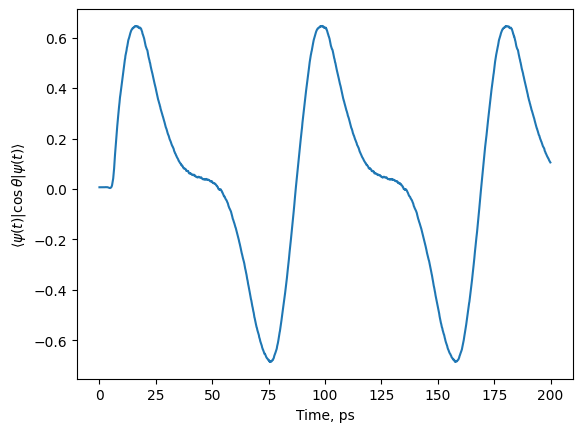

In [14]:
mol_vector = [0, 0, 1]
lab_vector = [np.dot(rot, mol_vector) for rot in rotation_matrix]

cos_theta = np.array([np.mean(vec[:, 2]) for vec in lab_vector])

plt.plot(time_list, cos_theta)
plt.xlabel('Time, ps')
plt.ylabel('$\\langle \\psi(t)|\\cos\\theta|\\psi(t)\\rangle$')
plt.show()

### Analytic evaluation of the degree of orientation

The matrix elements of some of functions of Euler angles can be evaluated analytically, similarly to the dipole moment matrix elements.

Here, we use analytic implementation of the $\langle \phi_{J',k_a',k_c',m'} |\cos\beta| \phi_{J,k_a,k_c,m}\rangle$ matrix elements, implemented in `stark.costheta_me_matrix`,
and compare it with the resutls of Monte-Carlo simulations.

In [15]:
from stark import costheta_me_matrix

# matrix elements <cos(beta)> in rotational field-free basis
costheta_matrix = costheta_me_matrix(max_j, rot_vec, linear=True)

# extract wavepacket coefficients
coefs = np.array([coef for (ind, time, coef) in coefs_time])  # (time, bas)

# transform matrix <cos(beta)> to wavepacket representation
costheta_time = np.einsum(
    "ti,kij,tj->t", np.conj(coefs), costheta_matrix, coefs, optimize="optimal"
)

# check if values are real
print("maximal imaginary component in <cos(beta)> (expected small):", np.max(np.abs(costheta_time.imag)))
costheta_time = costheta_time.real

maximal imaginary component in <cos(beta)> (expected small): 1.1246225847284796e-16


Plot results and compare with Monte-Carlo values.

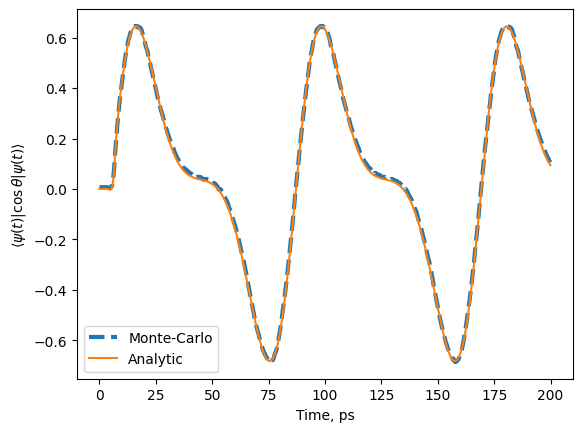

In [16]:
plt.plot(time_list, cos_theta, label="Monte-Carlo", linestyle='--', linewidth=3)
plt.plot(time_list, costheta_time, label="Analytic")
plt.xlabel('Time, ps')
plt.ylabel('$\\langle \\psi(t)|\\cos\\theta|\\psi(t)\\rangle$')
plt.legend()
plt.show()